In [ ]:
!python --version

Python 3.11.13


In [ ]:
import tensorflow
print(tensorflow.__version__)

2.18.0


In [ ]:
#https://keras.io/api/applications/

from tensorflow import keras
import numpy as np

In [1]:
from google.colab import files
import zipfile
import os

# Step 1: Upload file (select a ZIP file manually)
uploaded = files.upload()

# Step 2: Get uploaded zip file path
for filename in uploaded.keys():
    zip_path = f"/content/{filename}"

# Step 3: Check if it's a valid zip file
if zip_path.endswith(".zip"):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        extract_dir = "/content/extracted_data"
        zip_ref.extractall(extract_dir)
        print(f"✅ Extracted to: {extract_dir}")
else:
    raise ValueError("❌ The uploaded file is not a .zip archive.")




Saving CNN_OutputFolder.zip to CNN_OutputFolder.zip
✅ Extracted to: /content/extracted_data


In [2]:
#create data loaders
#https://keras.io/api/data_loading/

import tensorflow as tf
from tensorflow import keras
from keras import layers

train_ds = keras.utils.image_dataset_from_directory(
    directory='/content/extracted_data/CNN_OutputFolder/train',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(224, 224))
validation_ds = keras.utils.image_dataset_from_directory(
    directory='/content/extracted_data/CNN_OutputFolder/val',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(224, 224))


class_names = train_ds.class_names
num_classes = len(class_names)

# Normalize images
normalization_layer = layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
validation_ds = validation_ds.map(lambda x, y: (normalization_layer(x), y))


Found 8640 files belonging to 4 classes.
Found 1080 files belonging to 4 classes.


In [3]:
def build_model(base_model):
    base_model.trainable = False  # Freeze the base model
    model = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [4]:
from keras.applications import VGG19, MobileNetV3Small, ResNet50

base_models = {
    'VGG19': VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    'MobileNetV3Small': MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    'ResNet50': ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
}


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [5]:
results = {}

for name, base in base_models.items():
    print(f"\nTraining {name}...")
    model = build_model(base)

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    history = model.fit(train_ds,
                        validation_data=validation_ds,
                        epochs=20,
                        callbacks=[early_stop],
                        verbose=2)

    model.save(f"/content/{name}_FaceClassifier.keras")

    results[name] = history



Training VGG19...
Epoch 1/20
270/270 - 87s - 321ms/step - accuracy: 0.7554 - loss: 0.7208 - val_accuracy: 0.8861 - val_loss: 0.3689
Epoch 2/20
270/270 - 118s - 438ms/step - accuracy: 0.9005 - loss: 0.3115 - val_accuracy: 0.9296 - val_loss: 0.2218
Epoch 3/20
270/270 - 85s - 315ms/step - accuracy: 0.9324 - loss: 0.2135 - val_accuracy: 0.9491 - val_loss: 0.1505
Epoch 4/20
270/270 - 63s - 235ms/step - accuracy: 0.9487 - loss: 0.1640 - val_accuracy: 0.9667 - val_loss: 0.1124
Epoch 5/20
270/270 - 86s - 320ms/step - accuracy: 0.9559 - loss: 0.1358 - val_accuracy: 0.9398 - val_loss: 0.1597
Epoch 6/20
270/270 - 67s - 247ms/step - accuracy: 0.9603 - loss: 0.1189 - val_accuracy: 0.9657 - val_loss: 0.0932
Epoch 7/20
270/270 - 64s - 235ms/step - accuracy: 0.9666 - loss: 0.1062 - val_accuracy: 0.9676 - val_loss: 0.0791
Epoch 8/20
270/270 - 63s - 235ms/step - accuracy: 0.9700 - loss: 0.0893 - val_accuracy: 0.9694 - val_loss: 0.0794
Epoch 9/20
270/270 - 63s - 235ms/step - accuracy: 0.9690 - loss: 0.0

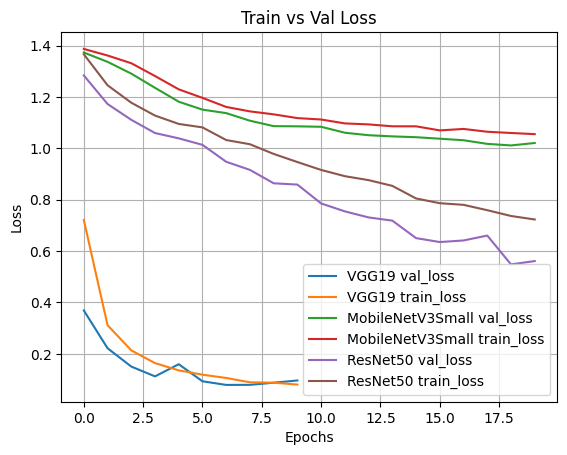

In [6]:
import matplotlib.pyplot as plt

def plot_history(histories):
    for name, hist in histories.items():
        plt.plot(hist.history['val_loss'], label=f'{name} val_loss')
        plt.plot(hist.history['loss'], label=f'{name} train_loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train vs Val Loss')
    plt.legend()
    plt.grid()
    plt.show()

plot_history(results)
